# Exercise 1 (advanced)

In this exercise you explore the most commonly used machine learning algorithms:
 - Linear Discriminant Analysis (also known as Fisher's Discriminant)
 - Decision Trees
 - Random Forests
 - Artificial Neural Networks
 
Execute the following cells by pressing "Shift + Enter", interpret the results and answer the questions.

**This is the advanced version of the excercises. You will require knowledge of Python and Numpy to solve the questions.**

## The SciPy Stack

The SciPy stack is a
**Python-based ecosystem of open-source software for mathematics, science, and engineering**

### The SciPy stack includes:
 * **IPython** Interactive python shell
 * **NumPy** N-dimensional array package and data format used in SciPy
 * **Matplotlib** Plotting and data visualization
 * **SciPy** Scientific computing: Integration, Optimization, Statistics, ...
 * **Pandas** Data structures & data analysis
 * **Sympy** Symbolic mathematics
 
Furthermore the SciPy stack includes a package for machine learning called **scikit-learn** (or short sklearn).
scikit-learn is a good package to take your first steps in machine learning. Later you probably want to change to a more performant and specialized package like:
  * XGBoost (https://github.com/dmlc/xgboost) for Gradient Boosting based on Decision Trees
  * Tensorflow (https://www.tensorflow.org/) for Artificial Neural Networks
  
**We won't use any of these libraries here. Remember this is the advanced exercise. Our goal is to understand the algorithms in detail, hence implement everything ourselves!**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Visualization

I already prepared two functions which create nice plots like you have seen in the lecture.
You should be able to understand the code below, otherwise you probably want to switch to the basic exercise.

In [2]:
def plot_data(X, y, classifier=None, show=True):
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], alpha=0.5, label='Signal')
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], alpha=0.5, label='Background')
    plt.legend(loc=1, bbox_to_anchor=(0.3, 1.2))
    if classifier is not None:
        supportX = np.arange(X[:, 0].min()-0.5, X[:, 0].max()+0.5, 0.05)
        supportY = np.arange(X[:, 1].min()-0.5, X[:, 1].max()+0.5, 0.05)
        GX, GY = np.meshgrid(supportX, supportY)
        GZ = classifier.predict(np.dstack([GX, GY]))
        plt.contourf(GX, GY, GZ, alpha=0.5, cmap='Greys', levels=np.linspace(GZ.min(), GZ.max(), 20))
        if hasattr(classifier, 'fisher'):
            plt.plot([-classifier.fisher[0]*3,classifier.fisher[0]*3],
                     [-classifier.fisher[1]*3,classifier.fisher[1]*3], 'k-',lw=4)
        if hasattr(classifier, 'root_node'):
            def draw(node, xmin, xmax, ymin, ymax):
                if 'purity' in node: return
                if node['feature'] == 0:
                    plt.vlines(x=node['value'], ymin=ymin, ymax=ymax, color='black')
                    draw(node['left'], xmin, node['value'], ymin, ymax)
                    draw(node['right'], node['value'], xmax, ymin, ymax)
                else:
                    plt.hlines(y=node['value'], xmin=xmin, xmax=xmax, color='black')
                    draw(node['left'], xmin, xmax, ymin, node['value'])
                    draw(node['right'], xmin, xmax, node['value'], ymax)
            draw(classifier.root_node, supportX.min(), supportX.max(), supportY.min(), supportY.max())
    if show:
        plt.show()
    
def plot_roc(X, y, classifier, show=True):
    p = classifier.predict(X)
    index = np.argsort(p)
    tpr = np.cumsum(y[index]) / y.sum()
    fpr = np.cumsum(1.0 - y[index]) / float(len(y) - y.sum())
    auc = np.trapz(fpr, tpr)
    plt.plot(tpr, fpr, lw=3, label='AUC {:3f}'.format(auc))
    plt.legend()
    if show:
        plt.show()

## Data

In this first exercise we will work only with a 2d classification task, like you have seen in the lecture.
The next cell contains two possible toy datasets:
  1. Problem 1: Signal and Background are drawn from a gaussian distribution with different means and covariances
  2. Problem 2: Signal is drawn from a gaussian distribution and the background is an open ring around the signal
  
Here we the more complex problem_2 as default, but you can switch to the simpler problem at any time to debug your code more easily.

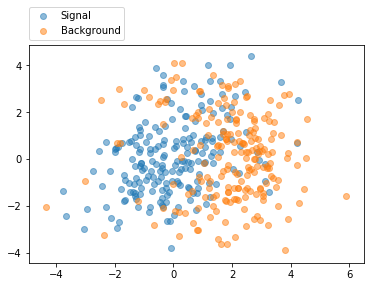

In [17]:
N = 200

def get_problem_1():
    signal = np.random.multivariate_normal([-1.0,-1.0],[[1.0,0.5],[0.5,1.0]],(N,))
    bckgrd = np.random.multivariate_normal([1.0,1.0],[[1.0,-0.5],[-0.5,1.0]],(N,))
    return signal, bckgrd

def get_problem_2():
    signal = np.random.multivariate_normal([0.0,0.0],[[2.0,1.0],[1.0,3.0]],(N,))
    r, phi = np.random.normal(3.0, size=(N,)), np.random.normal(0.0, 1, size=(N,))
    bckgrd = np.c_[r*np.cos(phi), r*np.sin(phi)]
    return signal, bckgrd

def get_data():
    X = np.vstack(get_problem_2())
    y = np.hstack([np.ones(N), np.zeros(N)])
    return X, y

X, y = get_data()
plot_data(X, y)

## Linear Discriminant Analysis

The linear discriminant analysis is probably the easiest technique you can imagine.
Strictly speaking it is not a machine learning technique, because it justs fits
a gaussian distribution to the signal and background.

I use the interface of sklearn for all classifiers during the exercise:
  1. Hyper-parameters are set in the constructor of the class.
  2. The classifier is fitted by passing a training dataset X and the truth y (containing the class labels: 1 for signal and 0 for background) to the **fit** method.
  3. The classifier calculates the signal-probability of unlabelled new data using the **predict** method (aside: in contrast to the sklearn classifiers we return a probability instead of the class label)
  
** Exercise 1 ** Execute the code below

** Exercise 2 ** Implement the Quadratic Discriminant Analysis by estimating the covariance of both classes separately and by applying the Neyman Pearson lemma. Is QDA better than LDA for this problem? Why (not)?

In [18]:
class LinearDiscriminantAnalysis(object):
    def fit(self, X, y):
        from numpy.linalg import inv
        numerator = np.mean(X[y == 1], axis=0) - np.mean(X[y == 0], axis=0)
        denominator = np.cov(X[y == 1].T) + np.cov(X[y == 0].T)
        self.fisher = np.dot(inv(denominator), numerator)
    def predict(self, X):
        return np.dot(X, self.fisher)

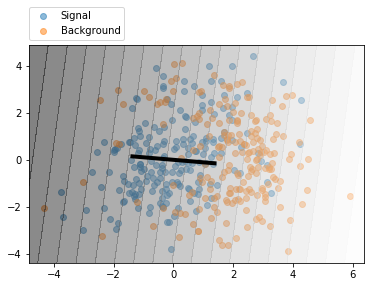

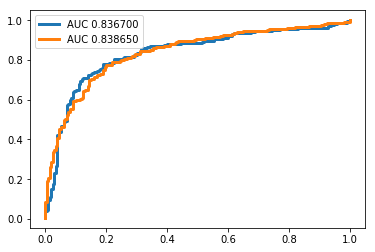

In [19]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
plot_data(X, y, lda)
plot_roc(X, y, lda, show=False)
plot_roc(*get_data(), lda)

## Decision Tree

Decision Trees are usually used with a boosting or bagging technique.
But they can also be used on their own.
Below you find a simple implementation of a decision tree.

** Exercise 1 ** Execute the code below. Understand the implementation

** Exercise 2 ** Plot the separation gain of some nodes in the tree by adding the separation_gain array to the node dictionary.

** Exercise 3 ** Exchange the separation measure "negative entropy" with the "gini-impurity" (see https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)

In [20]:
def get_neg_entropy(s, n):
    """
    Calculate the negative entropy
    @param s number of signal events
    @param n total number of events
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where((s == 0) | (s==n), 0, s * np.log2(s/n) + (n-s) * np.log2((n-s)/n))

def get_separation_gain(sorted_ys):
    """
    Calculate the separation gain for all possible cuts for all features
    @param sorted_ys 2d array with the truth values y sorted according to the values x of each feature
    """
    n = len(sorted_ys[0])
    s = sorted_ys[0].sum()
    sl = np.array([np.cumsum(sorted_y)[:-1] for sorted_y in sorted_ys])
    nl = np.array([np.arange(1, n) for sorted_y in sorted_ys])
    return get_neg_entropy(sl, nl) + get_neg_entropy(s - sl, n - nl)

class DecisionTree(object):
    """
    A simple decision tree
    """
    def __init__(self, max_depth=None):
        """
        Create a new decision tree.
        The whole tree is saved in form of nested dictionaries
        @param max_depth the maximum depth of the tree
        """
        self.root_node = {}
        self.max_depth = max_depth
        
    def fit(self, X, y):
        """
        Fit the tree
        @param X 2d array containing the features for each event
        @param y 1d array containing the truth label
        """
        self._fit(X, y, 0, self.root_node)
        
    def _fit(self, X, y, depth, node):
        """
        Fit a sub-tree. We call this function recursively
        @param X 2d array containing the features for each event which belongs to this sub-tree
        @param y 1d array containing the truth label which belongs to this subtree
        """
        # Check if maximum depth is reached
        if self.max_depth is not None and depth == self.max_depth:
            return {'purity': y.mean()}
        
        # Calculate best cut based on the separation gain
        index = np.argsort(X.T)
        separation_gain = get_separation_gain(y[index])
        best_cut = np.unravel_index(np.argmax(separation_gain), separation_gain.shape)
        
        # Now we fill our dictionary which represents the node of the tree
        node['feature'] = best_cut[0]
        node['value'] = X[index[best_cut[0], best_cut[1]], best_cut[0]]

        # If we have too few events left after the cut we stop growing deeper
        if best_cut[1] <= 1 or best_cut[1] >= len(index[best_cut[0]]) - 1:
            return {'purity': y.mean()}
        
        # Now we fit the left and right sub-tree using only the events which pass (or don't pass)
        # the best cut we found at this point
        left = index[best_cut[0], :best_cut[1]]
        right = index[best_cut[0], best_cut[1]:]
        node['left'] = self._fit(X[left], y[left], depth+1, {})
        node['right'] = self._fit(X[right], y[right], depth+1, {})
        return node
    
    def predict(self, X):
        """
        Calculate the signal-probability for each event
        @param X 2d array containing the features of each event
        """
        return np.apply_along_axis(self.predict_single, -1, X)

    def predict_single(self, x):
        """
        Unfortunately there is no way to perform the loop in numpy,
        therefore we have to use a slow Python loop here.
        """
        node = self.root_node
        while 'purity' not in node:
            node = node['left'] if x[node['feature']] < node['value'] else node['right']
        return node['purity']

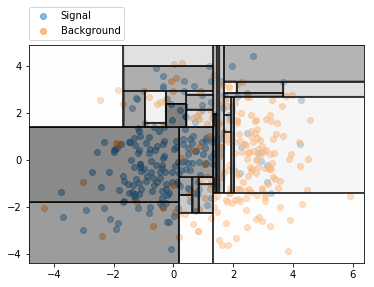

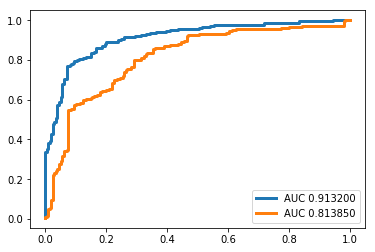

In [21]:
dt = DecisionTree(max_depth=10)
dt.fit(X, y)
plot_data(X, y, dt)
plot_roc(X, y, dt, show=False)
plot_roc(*get_data(), dt)

## Random Forest

As explained in the lecture over-fitting can be effectively prevented by averaging
many simple methods (so-called weak-learners) to obtain one robust complex model.

Here we implement a simple random forest. One advantage of random forest
over boosted decision trees is that you can train them easily in parallel.

** Exercise 1 ** Execute the code below. Understand the implementation.

** Exercise 2 ** Parallelize the code. Which speed-up do you observe.

In [22]:
import random

class RandomForest(object):
    "A simple random forest implementation"
    def __init__(self, ntrees=100, sampling_rate=0.5, max_depth=3):
        """
        Create a new random forest
        @param ntrees the number of trees in our forest
        @param sampling_rate the fraction of events from the training dataset used for fitting each tree
        @param max_depth the maximum depth of each individual tree
        """
        self.ntrees = ntrees
        self.sampling_rate = sampling_rate
        self.max_depth = max_depth
        
    def fit(self, X, y):
        """
        Fit the forest
        @param X 2d array containing the features for each event
        @param y 1d array containing the truth label
        """
        self.trees = []
        index = np.arange(len(X))
        for i in range(self.ntrees):
            # Select a random subsample of events (without replacement)
            index = random.sample(range(len(X)), int(len(X)*self.sampling_rate))
            # Fit a single Decision Tree
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X[index], y[index])
            self.trees.append(tree)
    
    def predict(self, X):
        """
        Predict the signal probability by averaging the response of each tree
        @param X 2d array containing the features for each event
        """
        return np.mean(np.array([tree.predict(X) for tree in self.trees]), axis=0)

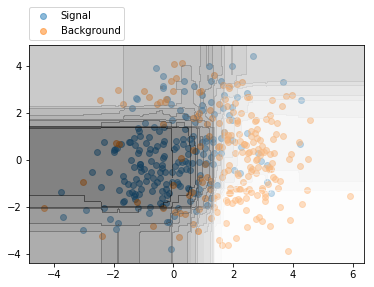

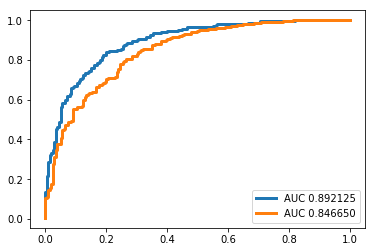

In [23]:
rf = RandomForest()
rf.fit(X, y)
plot_data(X, y, rf)
plot_roc(X, y, rf, show=False)
plot_roc(*get_data(), rf)

## Artificial Neural Network

Artificial neural networks are very hyped at the moment due to a concept called **deep learning**.
Here we restrict ourselves to **shallow learning**, that is a neural network with only one hidden layer.

** Exercise 1 ** Execute the code below. Understand the implementation.

** Exercise 2 ** Replace the activation function "tanh" with a relu

** Exercise 3 ** Implement **weight-decay** by adding $\lambda \sum_{ij} w_{ij}^2$ to the loss function. Hint: You have to calculate the derivative with respect to $w_{ij}$ and add this term to the update rule of the weights.

** Exercise 4 ** Implement a momentum term by remembering and adding the previous update to the current one $\Delta w_t = - \frac{\partial \mathcal{L}}{\partial w_t} + \alpha \Delta w_{t-1}$

In [24]:
class NeuralNetwork(object):
    """
    A simple neural network implementation
    """
    def __init__(self, n_input, n_hidden):
        """
        Create a new neural network
        @param n_input the number of input neurons
        @param n_hidden the number of neurons in the hidden layer
        """
        # We randomly initialize the weights, this is called symmetry breaking
        self.w_hi = np.random.normal(size=(n_input+1, n_hidden))
        self.w_oh = np.random.normal(size=n_hidden)

    def fit(self, X, y):
        """
        Fit the neural network
        @param X 2d array containing the features for each event
        @param y 1d array containing the truth label
        """
        # Append bias neuron
        X = np.apply_along_axis(lambda x: np.append(x, [1]), -1, X)
        # Scale y from [0, 1] to [-1, 1]
        y = 2 * y - 1
        for step in range(1, 1000):
            # Propagate input through hidden and output layer
            a_h = np.dot(X, self.w_hi)
            x_h = np.tanh(a_h)
            a_o = np.dot(x_h, self.w_oh)
            x_o = np.tanh(a_o)
            # Back-Propagate error signal
            d = lambda x: 4*np.cosh(x)**2/(np.cosh(2*x) + 1)**2
            e_o = d(a_o)*(x_o - y)
            e_h = d(a_h)*np.outer(e_o, self.w_oh)
            # Update weights: we slowly decrease our learning rate here
            self.w_oh -= 0.01/np.log(step+1) * np.dot(e_o.T, x_h)
            self.w_hi -= 0.01/np.log(step+1) * np.dot(X.T, e_h)

    def predict(self, X):
        """
        Predict the signal probability using the neural network
        @param X 2d array containing the features for each event
        """
        # Append bias neuron
        X = np.apply_along_axis(lambda x: np.append(x, [1]), -1, X)
        # Propagate input trough hidden layer
        x_h = np.tanh(np.dot(X, self.w_hi))
        # Propagate output of hidden layer through output layer
        return np.tanh(np.dot(x_h, self.w_oh))

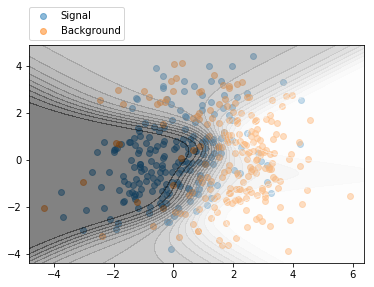

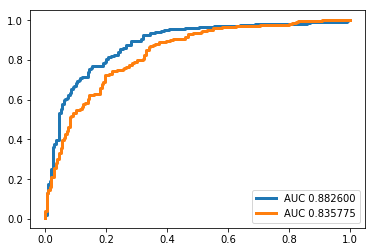

In [25]:
nn = NeuralNetwork(2, 4)
nn.fit(X, y)
plot_data(X, y, nn)
plot_roc(X, y, nn, show=False)
plot_roc(*get_data(), nn)